# Python Notebook to analyse classical non deep learning models
The following notebook loads local tensorflow datasets, creates a Kalman Filter (with a constant velocity model), Interacting Multiple Model approach (with constant velocity and constant tunr mdoel) and Particle Filter (with a constant velocity model). Further visualisation of predictions besides the ground truth as well as calculating the prediction accuracy and tuning hyperaparameters are available.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from imm import *
from simple_kalman import *
from bayes import *
from particle import *

2024-10-05 11:51:55.516510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 11:51:56.960405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline

# Load dataset
Load datasets from prebuild tensorflow datasets that inhibit data points with positions and poses in a trajectory.

In [27]:
synthetic_dataset =  "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_synth"
jrdb_original = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_orig"
jrdb_odometry_processed = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_odom"
eth_augmented = "/home/annalena/PedestrianTrajectoryPrediction/datasets/test_dataset_eth_aug"
crowdbot_odom = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test_data"
crowdbot_orig = "/home/annalena/PedestrianTrajectoryPrediction/datasets/crowdbot_test"

test_dataset =  tf.data.Dataset.load(crowdbot_odom)
test_dataset = tf.data.Dataset.unbatch(test_dataset)
test_dataset = test_dataset.batch(1000)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10221441867834611256


In [28]:
"""
Loads the trajectories with positions only from the datasets (are assumed to have positions and poses as trajectories)
"""

def get_traj_crowdbot(trajectory1, trajectory2):
    """
    Gets first and third component of 3D coordinate since that corresponds to the ground plane axis of the crowdbot dataset
    """
    return tf.gather(trajectory1, [0,2], axis=2)

def get_traj(trajectory1, trajectory2):
    """
    Gets the first two components of the 3D coordinate to get the gorund plane movement
    """
    return tf.gather(trajectory1, [0,1], axis=2)

def z_score_normalization(trajectory):
    """
    Apply z-score normalization to a trajectory.
    """
    # Calculate mean and standard deviation along the timestep axis
    mean = tf.reduce_mean(trajectory, axis=0)
    std = tf.math.reduce_std(trajectory, axis=0)
    
    # Apply z-score normalization
    normalized_trajectory = (trajectory - mean) / std
    return normalized_trajectory


test_dataset = test_dataset.map(get_traj_crowdbot)
# optionally apply normalisation
#test_dataset = test_dataset.map(z_score_normalization)

# Load model and predict
Get all models and if known set parameters fitting best to the chosen dataset.

In [29]:
model1 = Kalman_CV(pos_dim=2)
model2 = IMM_CVCT_2D(pos_dim=2)
model3 = ParticleFilter()

In [30]:
model1.params = {'P': 1.0, 'dt': 1, 'q': 0.1, 'r': 1} 
model2.params = {'P': 1.0, 'dt': 1, 'omega_variance': 0.1, 'q': 1.0, 'r': 1.0,
                 'M': [[0.70, 0.1, 0.1, 0.1],
                        [0.1, 0.7, 0.1, 0.1],
                        [0.1, 0.1, 0.7, 0.1],
                        [0.1, 0.1, 0.1, 0.7]], } 
model3.params = {'dt': 1, 'measurement_noise': 0.01, 'num_particles': 1000, 'process_noise_cv': 0.01}

Predict the next 10 timesteps from 5 history steps and get the execution time for each model.

In [31]:
import time
for batch_x1 in test_dataset.take(1):
    start_time = time.time()
    predictions1 = model1.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")
    start_time = time.time()
    predictions2 = model2.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")
    start_time = time.time()
    predictions3 = model3.predict(batch_x1)
    end_time = time.time()
    print(f"Execution Time: {end_time - start_time} seconds")

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10221441867834611256


Execution Time: 10.905065536499023 seconds
Execution Time: 10.002897262573242 seconds


/home/annalena/PedestrianTrajectoryPrediction/BayesFilter/particle.py:79: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Execution Time: 13.712893009185791 seconds


Plot a sample trajectory from the different models.

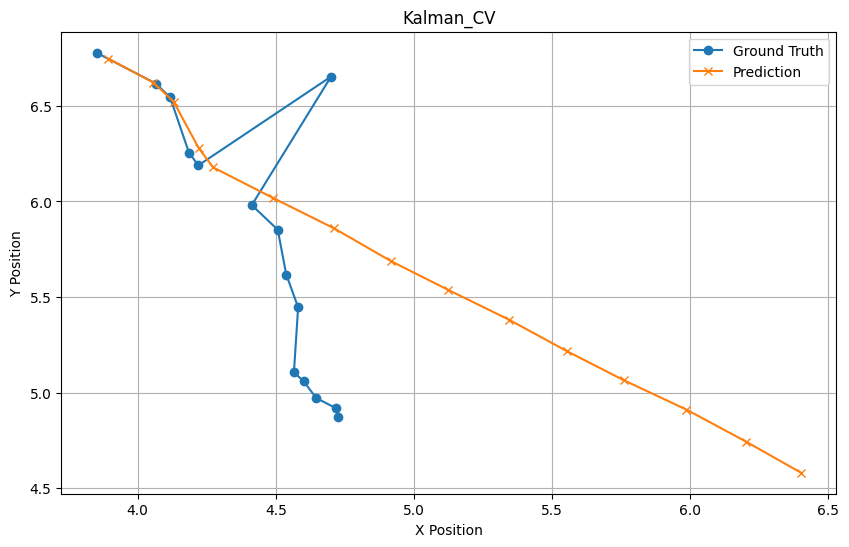

In [32]:
idx = 39
model1.plot_predictions(batch_x1[idx:], predictions3[idx:], sample_index=0)

# Visualise ADE and FDE

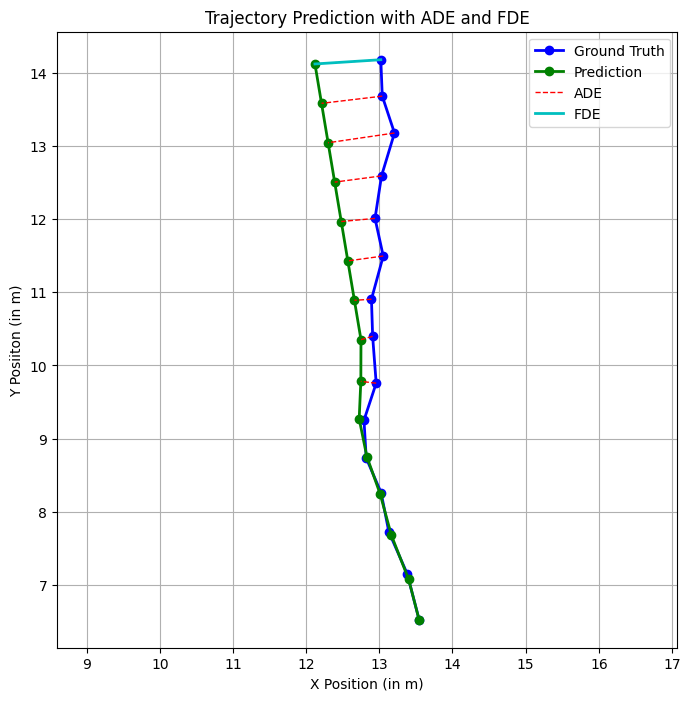

In [13]:
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))
plt.figure(figsize=(8, 8))

ground_truth= batch_x1[12][:15,:2]
prediction = predictions1[12][:15,:2]

plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth', linewidth=2)
plt.plot(prediction[:, 0], prediction[:, 1], 'go-', label='Prediction', linewidth=2)

# Calculate and plot ADE (Average Displacement Error)
for i in range(6,15):
    plt.plot([ground_truth[i, 0], prediction[i, 0]], [ground_truth[i, 1], prediction[i, 1]], 
             'r--', label='ADE' if i == 7 else "", linewidth=1)

# Highlight FDE (Final Displacement Error) with a different color
plt.plot([ground_truth[-1, 0], prediction[-1, 0]], [ground_truth[-1, 1], prediction[-1, 1]], 
         'c-', label='FDE', linewidth=2)

# Plot configuration
plt.xlabel('X Position (in m)')
plt.ylabel('Y Posiiton (in m)')
plt.title('Trajectory Prediction with ADE and FDE')
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')

# Show plot
plt.show()

# Plot classical methods predictions beside the HST prediction

In [14]:
# load hst predicitions 
with open('best_synth_pred.npy', 'rb') as f:
    hst_pred = np.load(f, allow_pickle=True)

In [40]:
# model multiple predicitions
def plot_predictions(ground_truth, predictions1, predictions2, predictions3, sample_index, tmpT=5):
        gt_x = ground_truth[sample_index, :, 0]
        gt_y = ground_truth[sample_index, :, 1]
        pred_x1 = predictions1[sample_index, tmpT:, 0]
        pred_y1 = predictions1[sample_index, tmpT:, 1]
        pred_x2 = predictions2[sample_index, tmpT:, 0]
        pred_y2 = predictions2[sample_index, tmpT:, 1]
        pred_x3 = predictions3[sample_index, tmpT:, 0]
        pred_y3 = predictions3[sample_index, tmpT:, 1]
        #pred_x4 = predictions4[sample_index, tmpT+1:, 0]
        #pred_y4 = predictions4[sample_index, tmpT+1:, 1]

        plt.figure(figsize=(10, 6))
        plt.plot(gt_x[tmpT:], gt_y[tmpT:], 'x-', color='black', label='Ground Truth')
        plt.plot(gt_x[:tmpT], gt_y[:tmpT], 'o-', color='black')
        plt.plot(pred_x1, pred_y1,'rx-',  label='KF')
        plt.plot(pred_x2, pred_y2,'bx-', label='IMM')
        plt.plot(pred_x3, pred_y3,'gx-',  label='PF')
        #plt.plot(pred_x4, pred_y4,'yx-',  label='HST')
        plt.xlabel('X Position (in m)')
        plt.ylabel('Y Position (in m)')
        plt.legend()
        plt.grid(True)
        plt.show()


Plot multiple trajectories

In [43]:
indexes = np.random.choice(1000, 10)
indexes

array([761, 518, 388, 570,  35, 735, 733, 518, 852,  36])

761


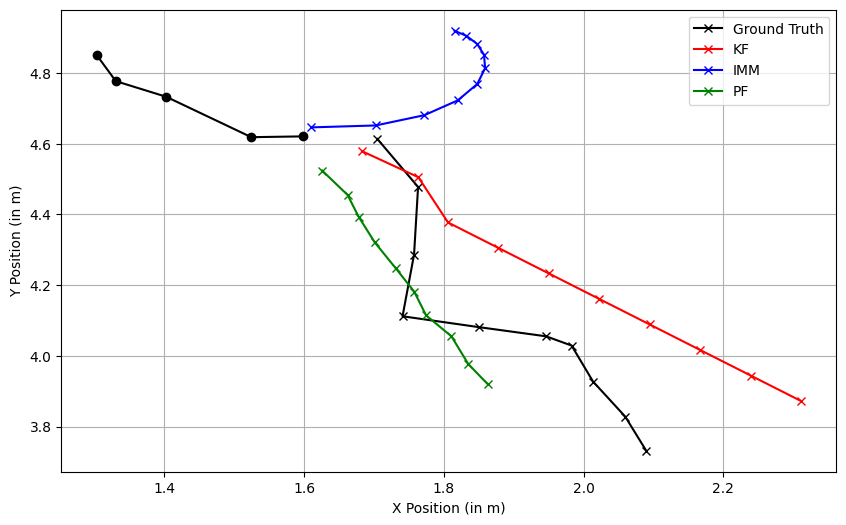

518


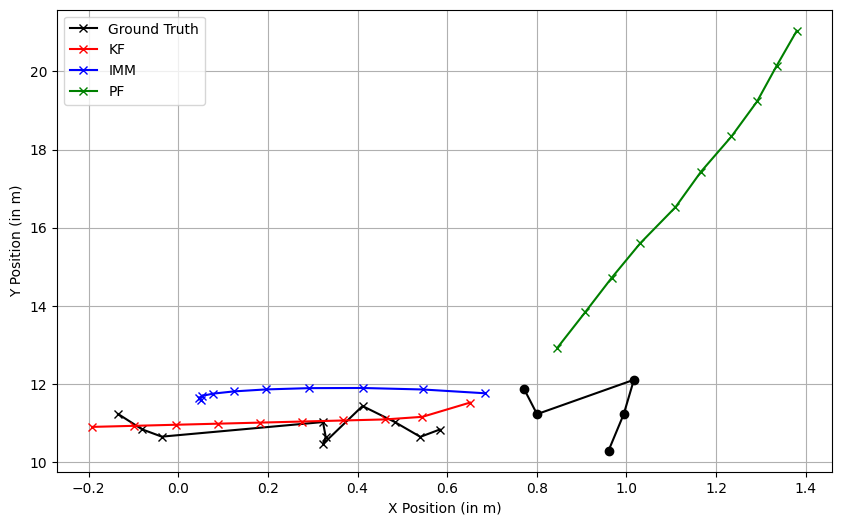

388


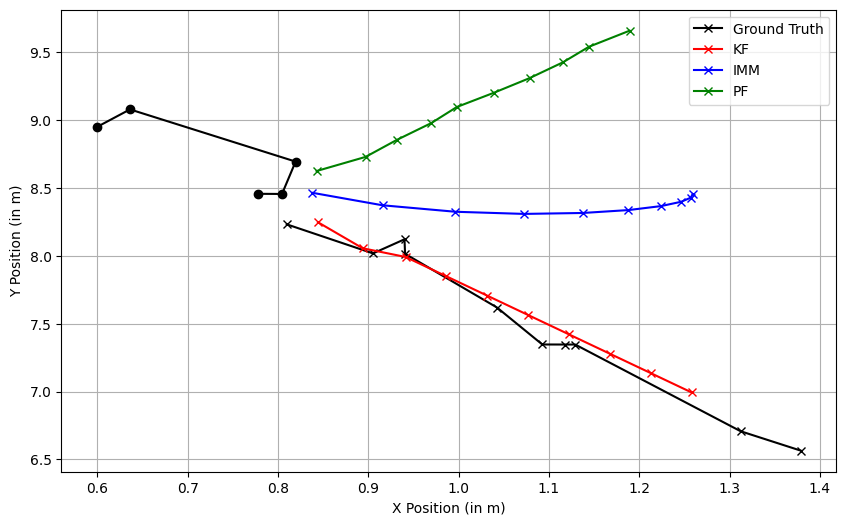

570


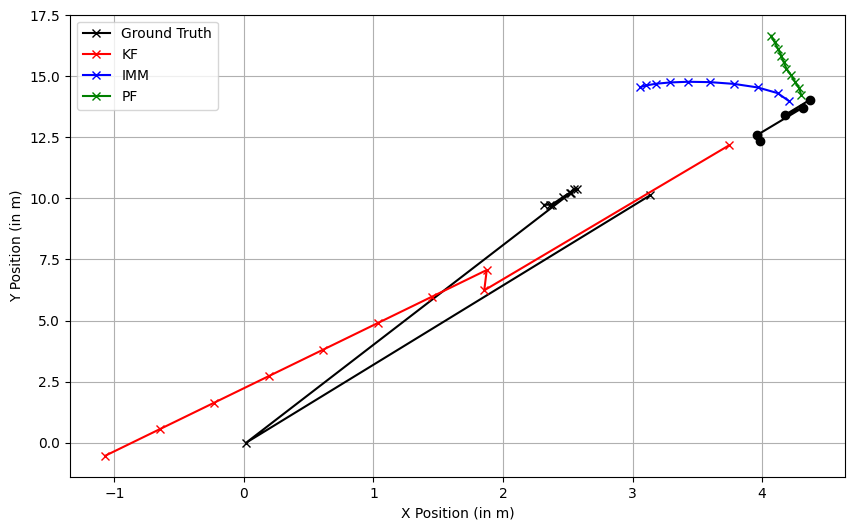

35


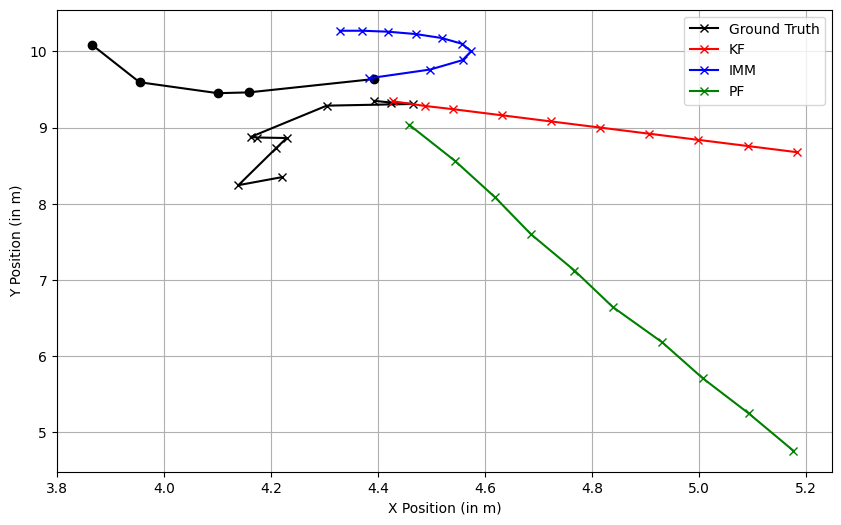

735


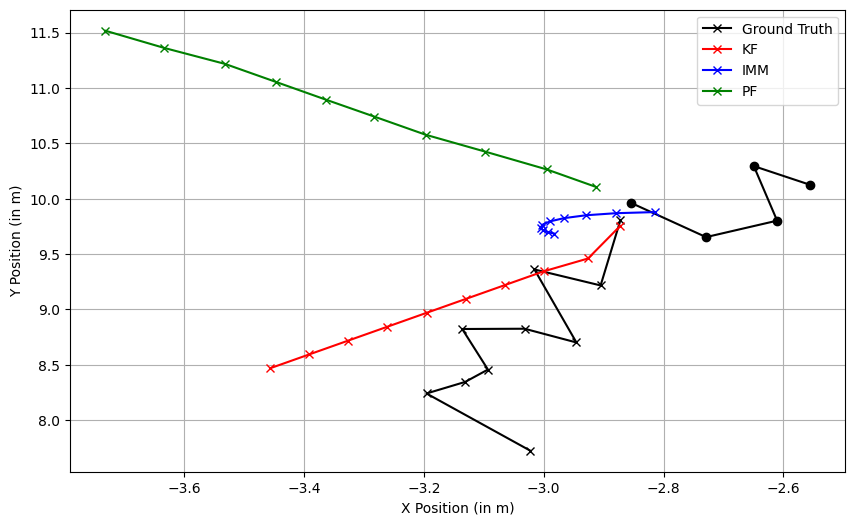

733


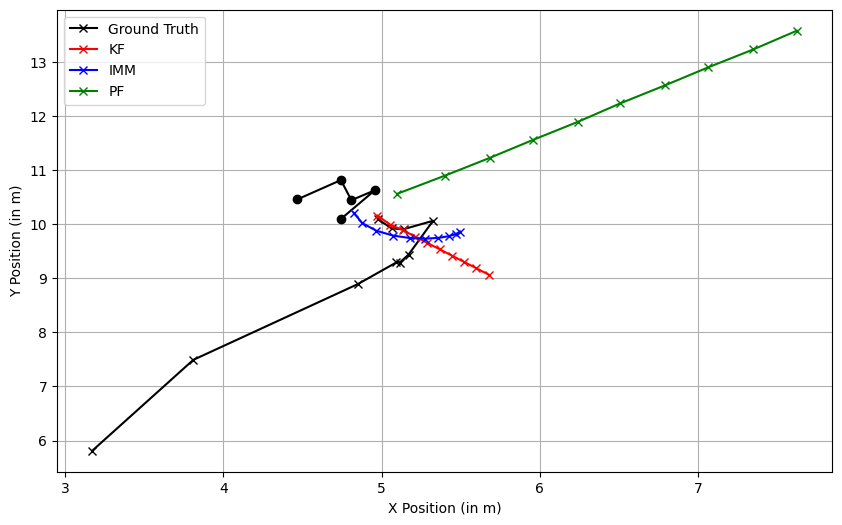

518


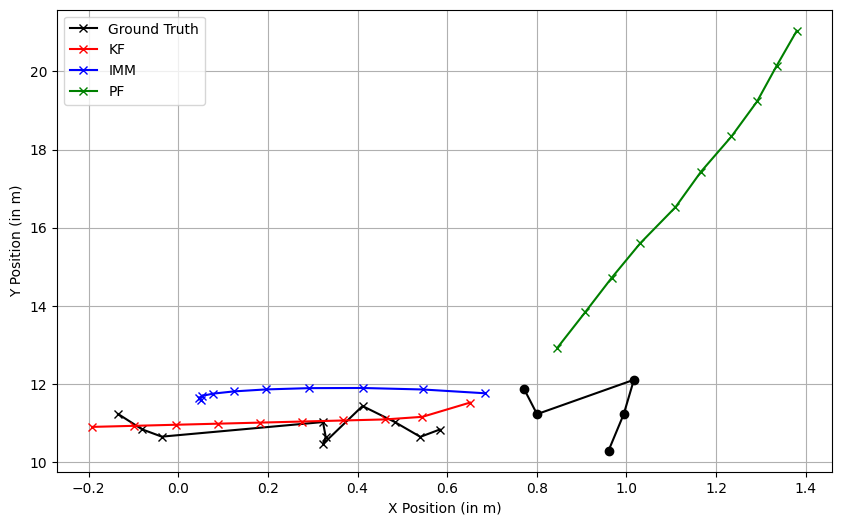

852


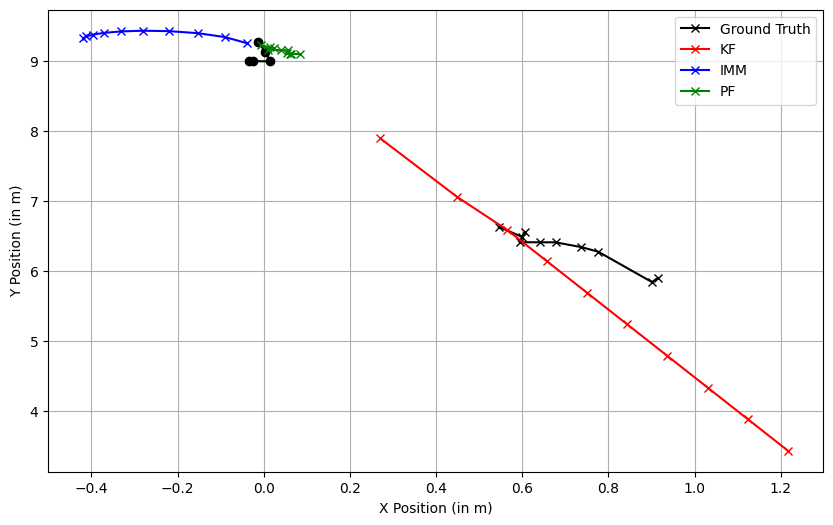

36


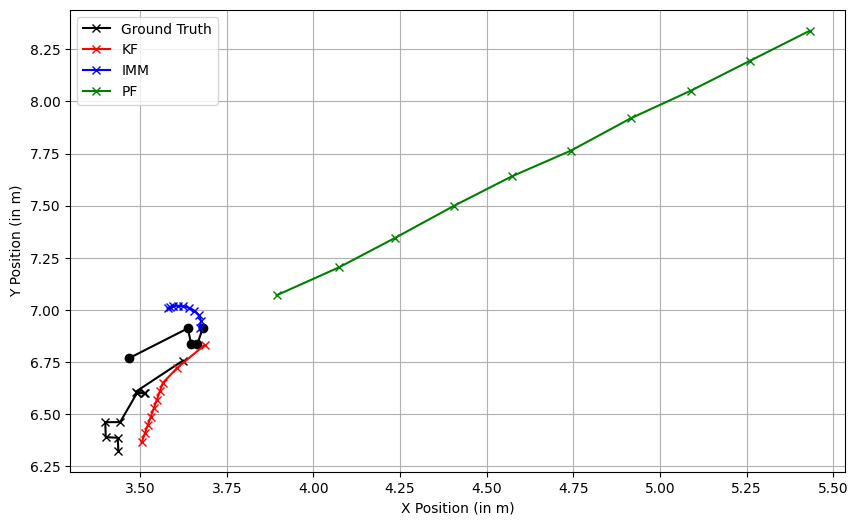

In [44]:
for idx in indexes:
    print(idx)
    plot_predictions(batch_x1[idx:], predictions1[idx:], predictions2[idx:], predictions3[idx:], sample_index=0)

# Calculate Prediction accuracies of the different methods

In [12]:
meanADE = model1.calculate_meanADE(batch_x1[:,6:,:2], predictions1[:,6:,:2])
meanFDE = model1.calculate_meanFDE(batch_x1[:,6:,:2], predictions1[:,6:,:2])
print("KF")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)
meanADE = model2.calculate_meanADE(batch_x1[:,6:,:2], predictions2[:,6:,:2])
meanFDE = model2.calculate_meanFDE(batch_x1[:,6:,:2], predictions2[:,6:,:2])
print("IMM")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)
meanADE = model3.calculate_meanADE(batch_x1[:,6:,:2], predictions3[:,6:,:2])
meanFDE = model3.calculate_meanFDE(batch_x1[:,6:,:2], predictions3[:,6:,:2])
print("PF")
print("mean ADE", meanADE)
print("mean FDE", meanFDE)

KF
mean ADE 0.30787962354035453
mean FDE 0.5726614986016371
IMM
mean ADE 1.8737119779302625
mean FDE 3.317056032250931
PF
mean ADE 0.8258020836650951
mean FDE 1.3472323375652064


# Hyperparameter Optimization

In [13]:
model1.hyperparameter_tuning(batch_x1[:,:,:2])

KeyboardInterrupt: 